



*   prepare the dataframe that include IVIS and SCFA measurements
*   use the IVIS and SCFA as condition to select what data should be selected to the final statistics. 
*   generate the consecutive data(bool)
*   do the behavior heatmap, lineplot and one-way ANOVA and Turkey test for each day
*   do the consecutive stacked barplot and Fishier exact test





upload file from local

In [1]:
'''
from google.colab import files
uploaded = files.upload()
'''
#%reset -f

'\nfrom google.colab import files\nuploaded = files.upload()\n'

upload file from gdrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.getcwd()

'/content'

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/DataColab/20210417 seizure score (date to day).csv')
df_ivis = pd.read_csv('/content/gdrive/MyDrive/DataColab/20210417 IVIS eye check.csv')
df_scfa = pd.read_csv('/content/gdrive/MyDrive/DataColab/20210417 SCFA measurement.csv')

eyeball the data



In [6]:
print(df.shape)
df.head(10)

(42, 9)


,group,subject,d1,d2,d3,d4,d5,d6,d7
0,A,A11,3,1,3,3,6,6,6
1,A,A12,3,0,1,6,6,6,6
2,A,A13,0,0,0,6,0,6,0
3,A,A14,1,6,6,6,6,6,6
4,A,A15,6,6,3,6,6,0,6
5,B,B11,3,0,0,3,6,6,6
6,B,B12,1,0,3,6,1,6,3
7,B,B13,0,0,0,0,0,0,0
8,B,B14,0,0,3,3,6,6,6
9,B,B15,6,3,3,3,0,6,6


In [7]:
df_ivis.head()

,group,subject,IVIS_d3
0,A,A11,0
1,A,A12,0
2,A,A13,0
3,A,A14,0
4,A,A15,0


In [8]:
df_ivis = df_ivis.rename(columns={'IVIS_d3':'ivis'})
del df_ivis['group']
df_ivis.head()

,subject,ivis
0,A11,0
1,A12,0
2,A13,0
3,A14,0
4,A15,0


In [9]:
df_scfa.head()

,group,animal number,Acetate,Propionate,Butyrate
0,A,A11,674,17.13,6.04
1,A,A12,627,16.95,5.98
2,A,A13,565,15.40,6.47
3,A,A14,526,14.43,5.14
4,A,A15,635,17.15,7.05


In [10]:
df_scfa = df_scfa.rename(columns={'animal number':'subject'})
del df_scfa['group']
df_scfa.columns= df_scfa.columns.str.lower()
df_scfa.head()

,subject,acetate,propionate,butyrate
0,A11,674,17.13,6.04
1,A12,627,16.95,5.98
2,A13,565,15.40,6.47
3,A14,526,14.43,5.14
4,A15,635,17.15,7.05


initialize new columns in df

In [11]:
df['ivis'] = np.nan
df['acetate'] = np.nan
df['propionate'] = np.nan
df['butyrate'] = np.nan
df.head()

,group,subject,d1,d2,d3,d4,d5,d6,d7,ivis,acetate,propionate,butyrate
0,A,A11,3,1,3,3,6,6,6,NaN,NaN,NaN,NaN
1,A,A12,3,0,1,6,6,6,6,NaN,NaN,NaN,NaN
2,A,A13,0,0,0,6,0,6,0,NaN,NaN,NaN,NaN
3,A,A14,1,6,6,6,6,6,6,NaN,NaN,NaN,NaN
4,A,A15,6,6,3,6,6,0,6,NaN,NaN,NaN,NaN


update with ivis and scfa data

In [12]:
df = df.set_index('subject')
df_ivis = df_ivis.set_index('subject')
df.update(df_ivis)
df.reset_index(inplace=True)
df_ivis.reset_index(inplace=True)

df = df.set_index('subject')
df_scfa = df_scfa.set_index('subject')
df.update(df_scfa)
df.reset_index(inplace=True)
df_scfa.reset_index(inplace=True)

print(df.shape)
df.head(10)

(42, 13)


,subject,group,d1,d2,d3,d4,d5,d6,d7,ivis,acetate,propionate,butyrate
0,A11,A,3,1,3,3,6,6,6,0.0,674.0,17.13,6.04
1,A12,A,3,0,1,6,6,6,6,0.0,627.0,16.95,5.98
2,A13,A,0,0,0,6,0,6,0,0.0,565.0,15.40,6.47
3,A14,A,1,6,6,6,6,6,6,0.0,526.0,14.43,5.14
4,A15,A,6,6,3,6,6,0,6,0.0,635.0,17.15,7.05
5,B11,B,3,0,0,3,6,6,6,1.0,621.0,18.48,5.16
6,B12,B,1,0,3,6,1,6,3,1.0,636.0,17.18,6.32
7,B13,B,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN
8,B14,B,0,0,3,3,6,6,6,1.0,671.0,16.05,6.28
9,B15,B,6,3,3,3,0,6,6,1.0,597.0,15.20,6.13


rm animals with these conditions:


1.   ivis: group B&C == 0
2.   acetate, propionate, butyrate: any of them == 0
3.   acetate, propionate, butyrate: group C < mean-SD



In [13]:
indexName = df[((df['group'] == 'C') & (df['ivis'] == 0)) | ((df['group'] == 'C') & (df['ivis'] == 0))].index
df.drop(indexName , inplace=True)

In [14]:
print(df.shape)
df.head(10)

(41, 13)


,subject,group,d1,d2,d3,d4,d5,d6,d7,ivis,acetate,propionate,butyrate
0,A11,A,3,1,3,3,6,6,6,0.0,674.0,17.13,6.04
1,A12,A,3,0,1,6,6,6,6,0.0,627.0,16.95,5.98
2,A13,A,0,0,0,6,0,6,0,0.0,565.0,15.40,6.47
3,A14,A,1,6,6,6,6,6,6,0.0,526.0,14.43,5.14
4,A15,A,6,6,3,6,6,0,6,0.0,635.0,17.15,7.05
5,B11,B,3,0,0,3,6,6,6,1.0,621.0,18.48,5.16
6,B12,B,1,0,3,6,1,6,3,1.0,636.0,17.18,6.32
7,B13,B,0,0,0,0,0,0,0,1.0,NaN,NaN,NaN
8,B14,B,0,0,3,3,6,6,6,1.0,671.0,16.05,6.28
9,B15,B,6,3,3,3,0,6,6,1.0,597.0,15.20,6.13


In [15]:
df = df.dropna()

In [16]:
print(df.shape)
df.head(10)

(33, 13)


,subject,group,d1,d2,d3,d4,d5,d6,d7,ivis,acetate,propionate,butyrate
0,A11,A,3,1,3,3,6,6,6,0.0,674.0,17.13,6.04
1,A12,A,3,0,1,6,6,6,6,0.0,627.0,16.95,5.98
2,A13,A,0,0,0,6,0,6,0,0.0,565.0,15.40,6.47
3,A14,A,1,6,6,6,6,6,6,0.0,526.0,14.43,5.14
4,A15,A,6,6,3,6,6,0,6,0.0,635.0,17.15,7.05
5,B11,B,3,0,0,3,6,6,6,1.0,621.0,18.48,5.16
6,B12,B,1,0,3,6,1,6,3,1.0,636.0,17.18,6.32
8,B14,B,0,0,3,3,6,6,6,1.0,671.0,16.05,6.28
9,B15,B,6,3,3,3,0,6,6,1.0,597.0,15.20,6.13
10,C11,C,0,0,6,6,0,6,6,1.0,648.0,17.48,7.16


In [17]:
df_C = df.loc[df['group'] == 'C']
Macetate = df_C.acetate.mean()
SDacetate = df_C.acetate.std()
print(Macetate, SDacetate)

Mpropionate = df_C.propionate.mean()
SDpropionate = df_C.propionate.std()
print(Mpropionate, SDpropionate)

Mbutyrate = df_C.butyrate.mean()
SDbutyrate = df_C.butyrate.std()
print(Mbutyrate, SDbutyrate)


indexName = df[((df['group'] == 'C') & (df['acetate'] < (Macetate - SDacetate))) | 
               ((df['group'] == 'C') & (df['propionate'] < (Mpropionate - SDpropionate))) | 
               ((df['group'] == 'C') & (df['butyrate'] < (Mbutyrate - SDbutyrate)))].index
print(indexName)
df.drop(indexName , inplace=True)



681.1818181818181 46.59145454226168
18.20818181818182 1.410246915840047
7.253636363636364 0.845213259802196
Int64Index([16], dtype='int64')


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


check the number in each group

In [18]:
print('number of A: ', len(df.loc[df['group'] == 'A']))
print('number of B: ', len(df.loc[df['group'] == 'B']))
print('number of C: ', len(df.loc[df['group'] == 'C']))
print('number of D: ', len(df.loc[df['group'] == 'D']))

number of A:  11
number of B:  8
number of C:  10
number of D:  3


add consecutive result as bool type

In [19]:
df['2cons'] = np.nan
df['3cons'] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
print(df.shape)
df.head(10)

(32, 15)


,subject,group,d1,d2,d3,d4,d5,d6,d7,ivis,acetate,propionate,butyrate,2cons,3cons
0,A11,A,3,1,3,3,6,6,6,0.0,674.0,17.13,6.04,NaN,NaN
1,A12,A,3,0,1,6,6,6,6,0.0,627.0,16.95,5.98,NaN,NaN
2,A13,A,0,0,0,6,0,6,0,0.0,565.0,15.40,6.47,NaN,NaN
3,A14,A,1,6,6,6,6,6,6,0.0,526.0,14.43,5.14,NaN,NaN
4,A15,A,6,6,3,6,6,0,6,0.0,635.0,17.15,7.05,NaN,NaN
5,B11,B,3,0,0,3,6,6,6,1.0,621.0,18.48,5.16,NaN,NaN
6,B12,B,1,0,3,6,1,6,3,1.0,636.0,17.18,6.32,NaN,NaN
8,B14,B,0,0,3,3,6,6,6,1.0,671.0,16.05,6.28,NaN,NaN
9,B15,B,6,3,3,3,0,6,6,1.0,597.0,15.20,6.13,NaN,NaN
10,C11,C,0,0,6,6,0,6,6,1.0,648.0,17.48,7.16,NaN,NaN


In [21]:
df_score = df.iloc[:,2:9]

In [22]:
def threeCons(my_list,df_target,ind_target): # input list and the target df for result filling
    all_occurrences = []
    last_found_index = -1
    element_found = True
    result = []

    while element_found:
        try:
            last_found_index = my_list.index(6, last_found_index + 1)
            all_occurrences.append(last_found_index)
        except ValueError:
            element_found = False
        
    if len(all_occurrences) == 0:
        df_target.loc[ind_target,'3cons'] = False
        print("The element wasn't found in the list")
    else:
        ind = [i for i in all_occurrences if i < 5]
        if len(ind) == 0:
            df_target.loc[ind_target,'3cons'] = False
            print('there is no 3 consecutive 6 in the list')
        else:
            for j in ind:
                if my_list[j+1]==6 & my_list[j+2]==6:
                    result.append(True)
                else:
                    result.append(False)
            if True in result:
                print('3 consecutive 6 exist in the list')
                df_target.loc[ind_target,'3cons'] = True
            else:
                print('there is no 3 consecutive 6 in the list')
                df_target.loc[ind_target,'3cons'] = False

In [23]:
for index, row in df_score.iterrows():
    ls = row.tolist()
    threeCons(ls,df,index)

3 consecutive 6 exist in the list
3 consecutive 6 exist in the list
there is no 3 consecutive 6 in the list
3 consecutive 6 exist in the list
there is no 3 consecutive 6 in the list
3 consecutive 6 exist in the list
there is no 3 consecutive 6 in the list
3 consecutive 6 exist in the list
there is no 3 consecutive 6 in the list
there is no 3 consecutive 6 in the list
there is no 3 consecutive 6 in the list
there is no 3 consecutive 6 in the list
there is no 3 consecutive 6 in the list
The element wasn't found in the list
there is no 3 consecutive 6 in the list
The element wasn't found in the list
The element wasn't found in the list
The element wasn't found in the list
The element wasn't found in the list
The element wasn't found in the list
there is no 3 consecutive 6 in the list
The element wasn't found in the list
there is no 3 consecutive 6 in the list
3 consecutive 6 exist in the list
there is no 3 consecutive 6 in the list
3 consecutive 6 exist in the list
there is no 3 consecuti

In [24]:
print(df.shape)
df.head(10)

(32, 15)


,subject,group,d1,d2,d3,d4,d5,d6,d7,ivis,acetate,propionate,butyrate,2cons,3cons
0,A11,A,3,1,3,3,6,6,6,0.0,674.0,17.13,6.04,NaN,True
1,A12,A,3,0,1,6,6,6,6,0.0,627.0,16.95,5.98,NaN,True
2,A13,A,0,0,0,6,0,6,0,0.0,565.0,15.40,6.47,NaN,False
3,A14,A,1,6,6,6,6,6,6,0.0,526.0,14.43,5.14,NaN,True
4,A15,A,6,6,3,6,6,0,6,0.0,635.0,17.15,7.05,NaN,False
5,B11,B,3,0,0,3,6,6,6,1.0,621.0,18.48,5.16,NaN,True
6,B12,B,1,0,3,6,1,6,3,1.0,636.0,17.18,6.32,NaN,False
8,B14,B,0,0,3,3,6,6,6,1.0,671.0,16.05,6.28,NaN,True
9,B15,B,6,3,3,3,0,6,6,1.0,597.0,15.20,6.13,NaN,False
10,C11,C,0,0,6,6,0,6,6,1.0,648.0,17.48,7.16,NaN,False


plot behavior scores and NHST


*   behavior line plot with shade(se)
*   test for normality for each group- shapiro test
*   test for homogeneity among groups - levene test
*   anova / ranksum


In [25]:
from scipy import stats
import seaborn as sns

In [26]:

days = df_score.columns.values.tolist()
sc_m = np.zeros((4,7))  # initialize a matrix for storing score means, group for rows, columns for days
sc_se = np.zeros((4,7))
shapiro_val = np.zeros((4,7))   # test normality, fill with p-val
shapiro_res = np.zeros((4,7))   # fill with True/False
levene_val = np.zeros((1,7))    # calculate homogeneity among groups per day
levene_res = np.zeros((1,7))    # 

for i in days:

    da = df.loc[df['group']=='A',i]   # a temporal df for group A
    sc_m[0,days.index(i)] = da.mean()
    sc_se[0,days.index(i)] = da.std() / (len(da) ** 0.5)
    shapiro_test = stats.shapiro(da)
    shapiro_val[0,days.index(i)] = shapiro_test[1]

    db = df.loc[df['group']=='B',i]   # a temporal df for group B
    sc_m[1,days.index(i)] = db.mean()
    sc_se[1,days.index(i)] = db.std() / (len(db) ** 0.5)
    shapiro_test = stats.shapiro(db)
    shapiro_val[1,days.index(i)] = shapiro_test[1]

    dc = df.loc[df['group']=='C',i]   # a temporal df for group C
    sc_m[2,days.index(i)] = dc.mean()
    sc_se[2,days.index(i)] = dc.std() / (len(dc) ** 0.5)
    shapiro_test = stats.shapiro(dc)
    shapiro_val[2,days.index(i)] = shapiro_test[1]

    dd = df.loc[df['group']=='D',i]   # a temporal df for group D
    sc_m[3,days.index(i)] = dd.mean()
    sc_se[3,days.index(i)] = dd.std() / (len(dd) ** 0.5)
    shapiro_test = stats.shapiro(dd)
    shapiro_val[3,days.index(i)] = shapiro_test[1]

    stat, p = stats.levene(da, db, dc, dd)    # levene test among groups per day
    levene_val[0,days.index(i)] = p

shapiro_res = shapiro_val < 0.05
levene_res = levene_val < 0.05

print('score mean: ')
print(pd.DataFrame(sc_m,columns = days))

print('score sem: ')
print(pd.DataFrame(sc_se,columns = days))

print('shapiro test pval: ')
print(pd.DataFrame(shapiro_val,columns = days))

print('shapiro test result')
print(pd.DataFrame(shapiro_res,columns = days))

print('levene test pval: ')
print(pd.DataFrame(levene_val,columns = days))

print('levene test result')
print(pd.DataFrame(levene_res,columns = days))


'''
    globals()['a_'+i] = df.loc[df['group']=='A',i]    # generate new vars
    globals()['b_'+i] = df.loc[df['group']=='B',i]
    globals()['c_'+i] = df.loc[df['group']=='C',i]
    globals()['d_'+i] = df.loc[df['group']=='D',i]

    a_d1 = df.loc[df['group']=='A','d1']
    a_d1_m = a_d1.mean()
    a_d1_se = a_d1.std() / (len(a_d1) ** 0.5)
'''

score mean: 
      d1        d2        d3        d4        d5        d6     d7
0  2.000  1.272727  1.818182  3.090909  4.181818  3.818182  3.000
1  1.375  2.625000  3.375000  1.875000  4.625000  5.000000  5.625
2  1.300  3.400000  4.000000  2.200000  1.800000  4.800000  2.700
3  0.000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000
score sem: 
         d1        d2        d3        d4        d5        d6        d7
0  0.587754  0.714663  0.584935  0.779913  0.685143  0.912720  0.809040
1  0.754451  1.051147  0.679745  0.789156  0.905095  0.681385  0.375000
2  0.789515  0.909212  0.856349  0.879394  0.916515  0.800000  0.943398
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
shapiro test pval: 
         d1        d2        d3        d4        d5        d6        d7
0  0.020607  0.000015  0.026233  0.019016  0.004714  0.000051  0.008046
1  0.004429  0.005711  0.036970  0.026968  0.000129  0.000194  0.000001
2  0.000021  0.002956  0.001240  0.001845  0.0000

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


"\n    globals()['a_'+i] = df.loc[df['group']=='A',i]    # generate new vars\n    globals()['b_'+i] = df.loc[df['group']=='B',i]\n    globals()['c_'+i] = df.loc[df['group']=='C',i]\n    globals()['d_'+i] = df.loc[df['group']=='D',i]\n\n    a_d1 = df.loc[df['group']=='A','d1']\n    a_d1_m = a_d1.mean()\n    a_d1_se = a_d1.std() / (len(a_d1) ** 0.5)\n"

In [27]:

def plot_lines (X, Y, ERR): 
  # this function will plot each row of Y with X, and add shaded error bars.
  # X should be an 1D array
  # Y means the central dot to be plot, here it should be prepared Y_mean array,
  # err means the prepared bar to be plot, here it should be prepared Y_se array 
    
    for i in range(Y.shape[0]):
        y = Y[i,:]
        err = ERR[i,:]
        plt.plot(X, y)
        plt.fill_between(X, y-err, y+err ,alpha=0.1)



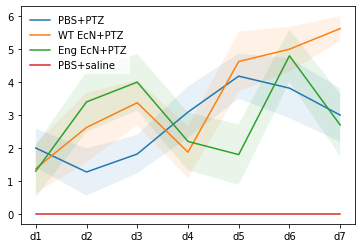

In [28]:
plot_lines(days,sc_m,sc_se)
leg = plt.legend(['PBS+PTZ', 'WT EcN+PTZ', 'Eng EcN+PTZ','PBS+saline'], loc='upper left')
#plt.legend(frameon=False)
leg.get_frame().set_linewidth(0.0)

from google.colab import files
#plt.savefig("seizure score.svg")
#files.download("seizure score.svg") 


do NHST for each day: Considering the lack of normality, we apply Kruskal–Wallis test and Post hoc pairwise test for multiple comparisons of mean rank sums (Dunn’s test).

In [29]:
!pip install scikit_posthocs
import scikit_posthocs as sp

     |████████████████████████████████| 43 kB 1.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37903 sha256=a4e0c9803402423ba04cea028f6883871bdfd6565aa47c572a6d6dd1198e2642
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:

days = df_score.columns.values.tolist()
kruskal_res = np.zeros((1,7))
kruskal_val = np.zeros((1,7))

for i in days:

    da = df.loc[df['group']=='A',i]   # a temporal df for group A
    db = df.loc[df['group']=='B',i]   # a temporal df for group B
    dc = df.loc[df['group']=='C',i]   # a temporal df for group C
    dd = df.loc[df['group']=='D',i]   # a temporal df for group D
    
    s,p  = stats.kruskal(da,db,dc,dd)
    kruskal_val[0,days.index(i)] = p
    kruskal_res = kruskal_val<0.05
    if p < 0.05:
        x = df[['group',i]]
        res1 = sp.posthoc_dunn(x,val_col = i, group_col = 'group')
        '''
        if res1 < 0.001:
            res1_res = '***'
        else:
              if res1<0.01:
                  res1_res = '**'
              else:
                  if res1<0.05:
                      res1_res = '*'
                  else:
                      res1_res = False
        '''
                    
        print(i)
        print(res1)
        print(res1<0.05)


d3
          A         B         C         D
A  1.000000  0.164956  0.056147  0.173936
B  0.164956  1.000000  0.689887  0.023748
C  0.056147  0.689887  1.000000  0.008975
D  0.173936  0.023748  0.008975  1.000000
       A      B      C      D
A  False  False  False  False
B  False  False  False   True
C  False  False  False   True
D  False   True   True  False
d5
          A         B         C         D
A  1.000000  0.720682  0.039118  0.017665
B  0.720682  1.000000  0.024418  0.011470
C  0.039118  0.024418  1.000000  0.327936
D  0.017665  0.011470  0.327936  1.000000
       A      B      C      D
A  False  False   True   True
B  False  False   True   True
C   True   True  False  False
D   True   True  False  False
d6
          A         B         C         D
A  1.000000  0.363081  0.415834  0.033783
B  0.363081  1.000000  0.887515  0.007666
C  0.415834  0.887515  1.000000  0.008282
D  0.033783  0.007666  0.008282  1.000000
       A      B      C      D
A  False  False  False   True
B

Fishier exact test and stacked bar plot for the consecutive data

fishier exact test should use number cross tab as input



cross_tab number
3cons  False  True
group             
A          8     3
B          4     4
C          9     1
D          3     0
cross_tab_prop
3cons     False      True
group                    
A      0.727273  0.272727
B      0.500000  0.500000
C      0.900000  0.100000
D      1.000000  0.000000
['oddsratio = ', 0.1111111111111111, 'pvalue = ', 0.1176470588235294]
cross_tab proportion
3cons  False  True
group             
A          8     3
B          4     4
C          9     1
D          3     0


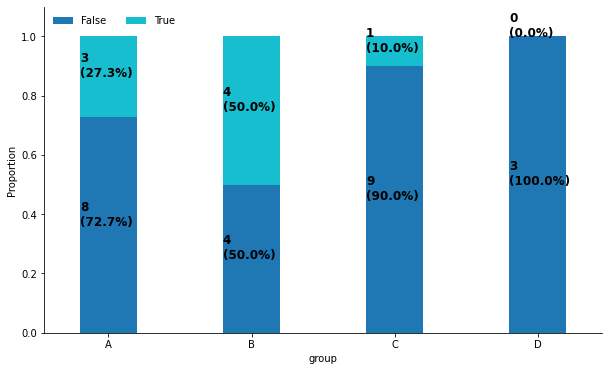

In [58]:


# plot 100% stacked charts in Python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df[['group','2cons','3cons']]

# creat cross tabulati, showing proportion in each treatment
cross_tab_num = pd.crosstab(index=data['group'],
                             columns=data['3cons'])
print('cross_tab number')
print(cross_tab_num)

cross_tab_prop = pd.crosstab(index=data['group'],
                             columns=data['3cons'],
                             normalize="index")
print('cross_tab_prop')
print(cross_tab_prop)

from scipy.stats import fisher_exact
fishierTable = cross_tab_num.loc[['B','C']].to_numpy()   #compute the pval of B and C groups
#fishierTable = np.transpose(fishierTable)
#print(fishierTable)
oddsratio, pvalue = fisher_exact(fishierTable, alternative='two-sided')
print(['oddsratio = ',oddsratio, 'pvalue = ', pvalue])



# creat cross tabulation, showing number in each treatment
cross_tab = pd.crosstab(index=data['group'],
                        columns=data['3cons'])
print('cross_tab proportion')
print(cross_tab)

# plot
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False   # remove top and right axis
mpl.rcParams['axes.spines.top'] = False

cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10',
                    width = 0.4,
                    rot = 0,
                    figsize=(10, 6),
                    ylim=(0,1.1))


leg = plt.legend(loc="upper left", ncol=2)
leg.get_frame().set_linewidth(0.0)

plt.xlabel("group")
plt.ylabel("Proportion")



for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n-0.2,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

#plt.savefig("consecutive propotion.svg")
#files.download("consecutive propotion.svg") 

In [53]:
cross_tab_num = pd.crosstab(index=data['group'],
                             columns=data['3cons'])
print(cross_tab_num)

3cons  False  True
group             
A          8     3
B          4     4
C          9     1
D          3     0


In [32]:
'''
def is_picklable(obj):
    try:
        pickle.dumps(obj)
    except Exception:
        return False
    return True


import pickle
bk = {}
for k in dir():
    obj = globals()[k]
 
    
    if is_picklable(obj):
        try:
            bk.update({k: obj})
        except TypeError:
            pass
    
# to save session
with open('/content/gdrive/MyDrive/Colab workspace/20220315 probiotics behavior ana vars-2.pickle', 'wb') as f:
    pickle.dump(bk, f)
'''

"\ndef is_picklable(obj):\n    try:\n        pickle.dumps(obj)\n    except Exception:\n        return False\n    return True\n\n\nimport pickle\nbk = {}\nfor k in dir():\n    obj = globals()[k]\n \n    \n    if is_picklable(obj):\n        try:\n            bk.update({k: obj})\n        except TypeError:\n            pass\n    \n# to save session\nwith open('/content/gdrive/MyDrive/Colab workspace/20220315 probiotics behavior ana vars-2.pickle', 'wb') as f:\n    pickle.dump(bk, f)\n"

In [33]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
import pickle
with open('/content/gdrive/MyDrive/Colab workspace/20220315 probiotics behavior ana vars-2.pickle', 'rb') as f:
    bk_restore = pickle.load(f)
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\nimport pickle\nwith open('/content/gdrive/MyDrive/Colab workspace/20220315 probiotics behavior ana vars-2.pickle', 'rb') as f:\n    bk_restore = pickle.load(f)\n"

In [34]:

def gen_randSymb(symb):   # the input symb should be an array has the same shape with the array that need to add symbols.
    #x = np.random.rand(10) .* symb
    i = 0
    while i < symb.size:
        if symb[i] < 0.5:
            symb[i] = -1
        else:
            symb[i] = 1
        i = i+1
    return symb

plot acetate, propionate and butyrate

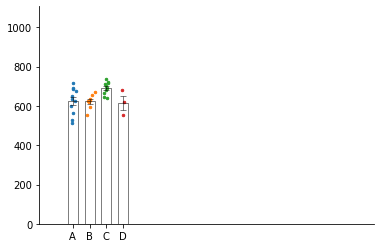

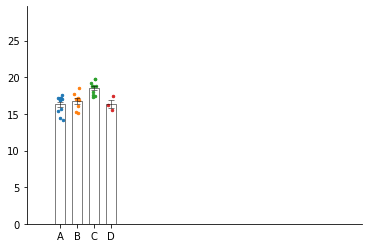

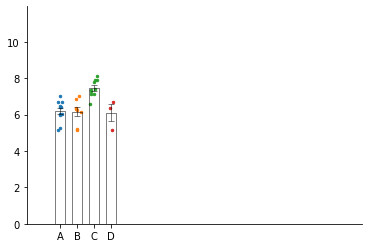

In [50]:
scfa = ['acetate', 'propionate','butyrate']
for s in scfa:
    # scatter plot 
    fig, ax = plt.subplots()
    groups = ['A','B','C','D']
    y_m = np.zeros(4)
    y_std = np.zeros(4)
    y_se = np.zeros(4)
    for i in range(len(groups)):
      y = df.loc[df['group'] == groups[i],s]
      x = 0.5* i * np.ones(y.shape) 
      symb = np.random.rand(y.shape[0])
      symb = gen_randSymb(symb)
      x = x + symb * 0.05 * np.random.randn(y.shape[0])
      plt.scatter(x,y,s=6)
      y_m[i] = y.mean()
      y_std[i] = y.std()
      y_se[i] = y.std() / (y.shape[0] ** 0.5)
      
    # barplot
    x_pos = np.arange(0,2,0.5)
    plt.bar(x_pos, y_m, 
            width = 0.3,
            color='None', 
            edgecolor='black',
            linewidth = 0.5,
            tick_label = groups)
    plt.xlim(-1,9)
    plt.ylim(0, 1.6 * np.amax(y_m))

    #plot errorbars
    ax.errorbar(x_pos, y_m, yerr=y_se, 
                fmt='none', # none setting can make the line not visiable
                ecolor='black', 
                capsize=3, 
                elinewidth = 0.5, 
                capthick = 0.5)

    ax.spines['top'].set_visible(False)   # remove the axis on the top
    ax.spines['right'].set_visible(False) # remove the axis on the right

    #plt.rc('font', size=12)          # controls default text sizes
    #from matplotlib.pyplot import figure
    # figure(figsize=(8, 6), dpi=300)   # figure size
    #plt.savefig("butyrate.svg")
    #files.download("butyrate.svg")

In [49]:
np.amax(y_m)

691.8

ANOVA and turkey test of scfa

In [36]:
# nomorlity test
shapiro_val = np.zeros(4)   # test normality, fill with p-val
shapiro_res = np.zeros(4)   # fill with True/False


for i in range(len(groups)):
    y = df.loc[df['group'] == groups[i],'butyrate']
    shapiro_test = stats.shapiro(y)
    shapiro_val[i] = shapiro_test[1]

print(shapiro_val)

[0.32940537 0.25510874 0.58724064 0.40432617]


In [37]:
print(shapiro_val)

[0.32940537 0.25510874 0.58724064 0.40432617]


all scfa are normally distributed. The homogeneity.

In [38]:
scfa = ['acetate','propionate','butyrate']
levene_val = np.zeros(3)   # fill with True/False

for i in range(len(scfa)):
    y1 = df.loc[df['group'] == 'A',scfa[i]]
    y2 = df.loc[df['group'] == 'B',scfa[i]]
    y3 = df.loc[df['group'] == 'C',scfa[i]]
    y4 = df.loc[df['group'] == 'D',scfa[i]]
    stat, p = stats.levene(y1, y2, y3, y4)    # levene test among groups per day
    levene_val[i] = p

print(levene_val)

[0.13960564 0.92235411 0.92286197]


every scfa are have homogeneity, we can use one-way ANOVA

(This part is unsuccessful)

In [39]:
scfa = ['acetate','propionate','butyrate']
anova_val = np.zeros(3)   # fill with True/False

for i in range(len(scfa)):
    y1 = df.loc[df['group'] == 'A',scfa[i]]
    y2 = df.loc[df['group'] == 'B',scfa[i]]
    y3 = df.loc[df['group'] == 'C',scfa[i]]
    y4 = df.loc[df['group'] == 'D',scfa[i]]
    
    len_max = max(len(y1),len(y2),len(y3),len(y4))
    y = [y1,y2,y3,y4]
    for i in range(len(y)):
      if len(y[i])<len_max:
        nanArray = np.empty((len_max - len(y[i]),1))
        nanArray[:] = np.nan
        nanArray = pd.DataFrame(nanArray)
        y[i] = pd.concat([y[i],nanArray])
    y1 = y[0].squeeze().array
    y2 = y[1].squeeze().array
    y3 = y[2].squeeze().array
    y4 = y[3].squeeze().array
    F,p = stats.f_oneway(y1,y2,y3)
    print(p)

print(anova_val)



nan
nan
nan
[0. 0. 0.]


switch to kruskal test, because I don't know how to do ANOVA in python for the number of groups are different

In [41]:
scfa = ['acetate','propionate','butyrate']

kruskal_res = np.zeros(3)
kruskal_val = np.zeros(3)

for i in range(len(scfa)):
    y1 = df.loc[df['group'] == 'A',scfa[i]]
    y2 = df.loc[df['group'] == 'B',scfa[i]]
    y3 = df.loc[df['group'] == 'C',scfa[i]]
    y4 = df.loc[df['group'] == 'D',scfa[i]]
    '''
    len_max = max(len(y1),len(y2),len(y3),len(y4))
    y = [y1,y2,y3,y4]
    for i in range(len(y)):
      if len(y[i])<len_max:
        nanArray = np.empty((len_max - len(y[i]),1))
        nanArray[:] = np.nan
        nanArray = pd.DataFrame(nanArray)
        y[i] = pd.concat([y[i],nanArray])
    y1 = y[0].squeeze().array
    y2 = y[1].squeeze().array
    y3 = y[2].squeeze().array
    y4 = y[3].squeeze().array
    
    F,p = stats.f_oneway(y1,y2,y3)
    print(p)
    '''
    s,p  = stats.kruskal(y1,y2,y3,y4)
    kruskal_val[i] = p

    if p < 0.05:
        x = df[['group',scfa[i]]]
        res1 = sp.posthoc_dunn(x,val_col = scfa[i], group_col = 'group')
        print(scfa[i])
        print(res1)
        print(res1<0.05)

kruskal_res = kruskal_val<0.05
print(kruskal_val)
print(kruskal_res)

acetate
          A         B         C         D
A  1.000000  0.543565  0.012589  0.592217
B  0.543565  1.000000  0.003810  0.921605
C  0.012589  0.003810  1.000000  0.028804
D  0.592217  0.921605  0.028804  1.000000
       A      B      C      D
A  False  False   True  False
B  False  False   True  False
C   True   True  False   True
D  False  False   True  False
propionate
          A         B         C         D
A  1.000000  0.600241  0.000187  0.924919
B  0.600241  1.000000  0.003418  0.787916
C  0.000187  0.003418  1.000000  0.017028
D  0.924919  0.787916  0.017028  1.000000
       A      B      C      D
A  False  False   True  False
B  False  False   True  False
C   True   True  False   True
D  False  False   True  False
butyrate
          A         B         C         D
A  1.000000  0.885986  0.000278  1.000000
B  0.885986  1.000000  0.000485  0.921605
C  0.000278  0.000485  1.000000  0.015827
D  1.000000  0.921605  0.015827  1.000000
       A      B      C      D
A  False  Fa